# Explainable AI (XAI)

### Data Mining Project 2024/25

Authors: Nicola Emmolo, Simone Marzeddu, Jacopo Raffi

In [1]:
#to find the best set of parameter setting, we can run a grid search
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report
import shap
import pickle

In [2]:
RANDOM_STATE = 42
dev_set = pd.read_csv('../data/ml_datasets/undersampling/dev_set.csv').sample(frac = 1, random_state=RANDOM_STATE) # shuffling the data so not to introduce bias
test_set = pd.read_csv('../data/ml_datasets/undersampling/test_set.csv')

In [3]:
dev_set['race_season%autumn'] = dev_set['race_season%autumn'].astype(int)
dev_set['race_season%spring'] = dev_set['race_season%spring'].astype(int)
dev_set['race_season%summer'] = dev_set['race_season%summer'].astype(int)
dev_set['race_season%winter'] = dev_set['race_season%winter'].astype(int)

test_set['race_season%autumn'] = test_set['race_season%autumn'].astype(int)
test_set['race_season%spring'] = test_set['race_season%spring'].astype(int)
test_set['race_season%summer'] = test_set['race_season%summer'].astype(int)
test_set['race_season%winter'] = test_set['race_season%winter'].astype(int)

In [4]:
dev_label = dev_set.pop('label')
test_label = test_set.pop('label')

In [5]:
RANDOM_STATE = 42
RUS = RandomUnderSampler(random_state=RANDOM_STATE)
dev_set, dev_label = RUS.fit_resample(dev_set, dev_label)

In [6]:
model = XGBClassifier(n_estimators=200, max_depth=13, learning_rate=0.108715)
model.fit(dev_set, dev_label)

test_predicitions = model.predict(test_set)
dev_predictions = model.predict(dev_set)

In [7]:
report = classification_report(test_label, test_predicitions, output_dict=True)

In [8]:
perturbation_data = dev_set
perturbation_labels = dev_label
perturbation_predictions = dev_predictions

explanation_data = test_set
explanation_labels = test_label
explanation_predictions = test_predicitions

explanations = dict()

In [9]:
interventional_explanation_algorithm = shap.TreeExplainer(
    model=model,
    data=dev_set,                       # perturb on a causal model induced on perturbation data
    feature_perturbation="interventional"  # use a causal model
)

distributional_explanation_algorithm = shap.TreeExplainer(
    model=model,
    feature_perturbation="tree_path_dependent"  # condition on the distribution learned on the train data
)

In [ ]:
# interventional_explanations = interventional_explanation_algorithm(explanation_data)
# distributional_explanations = distributional_explanation_algorithm(explanation_data)

# with open('interventional_explanations.pkl', 'wb') as f:
#     pickle.dump(interventional_explanations, f)

# with open('distributional_explanations.pkl', 'wb') as f:
#     pickle.dump(distributional_explanations, f)

In [11]:
interventional_explanations = pickle.load(open('interventional_explanations.pkl', 'rb'))
distributional_explanations = pickle.load(open('distributional_explanations.pkl', 'rb'))

explanations["shap_interventional"] = interventional_explanations.values
explanations["shap_distributional"] = distributional_explanations.values

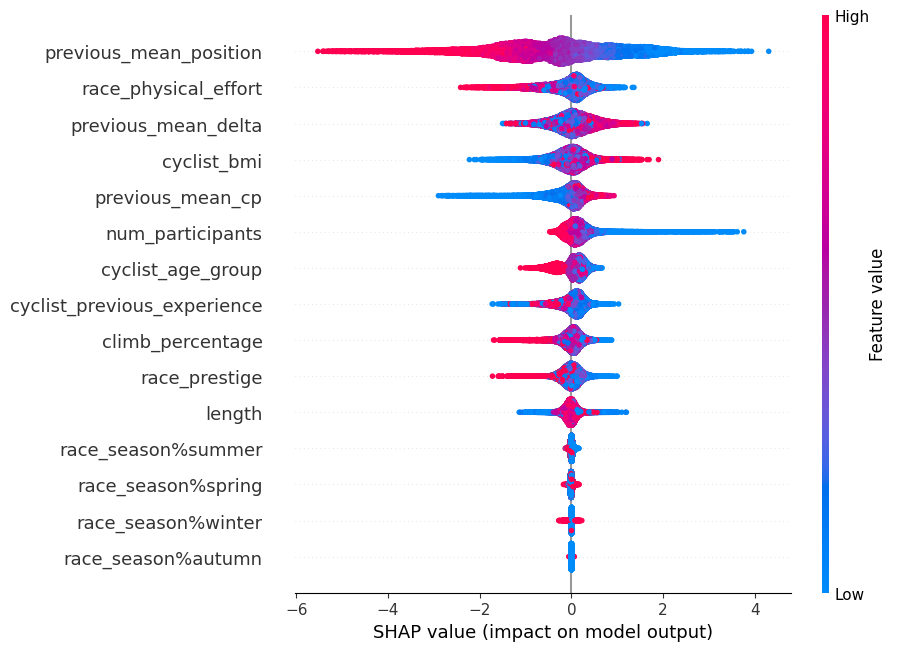

In [12]:
shap.plots.beeswarm(interventional_explanations, max_display=20)

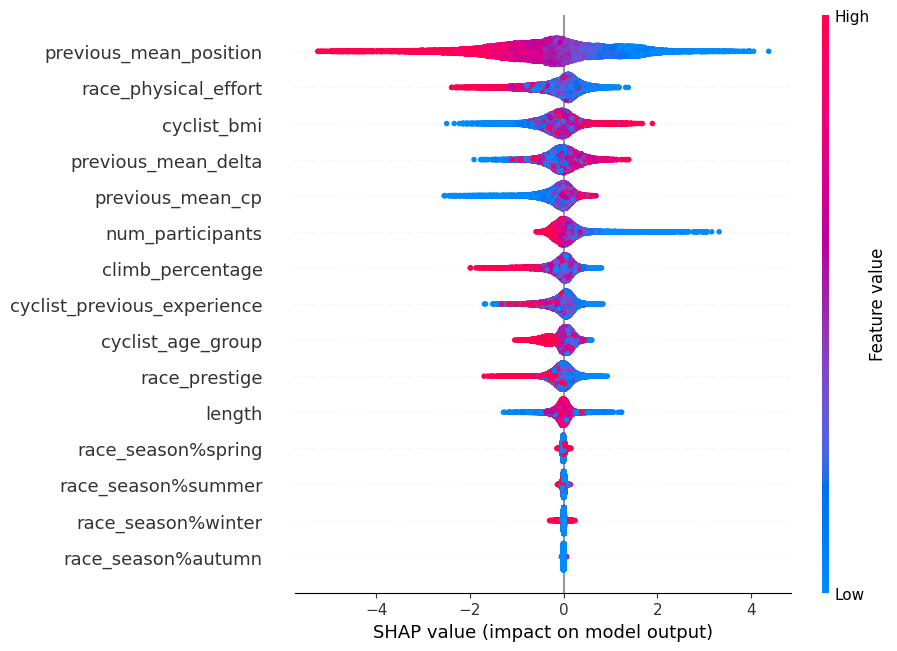

In [13]:
shap.plots.beeswarm(distributional_explanations, max_display=20)

In [14]:
explanation_differences = interventional_explanations.values - distributional_explanations.values
scaling_value = max((abs(interventional_explanations.values).max(), abs(distributional_explanations.values).max()))
maximum_differences_per_instance = explanation_differences.max(axis=1)
maximum_differences_per_feature = explanation_differences.max(axis=0)

<Axes: ylabel='Density'>

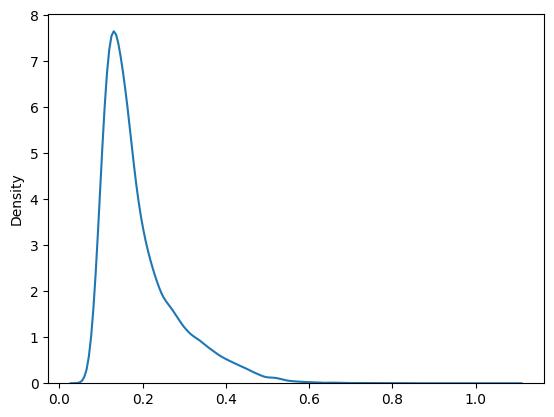

In [15]:
sb.kdeplot(maximum_differences_per_instance)

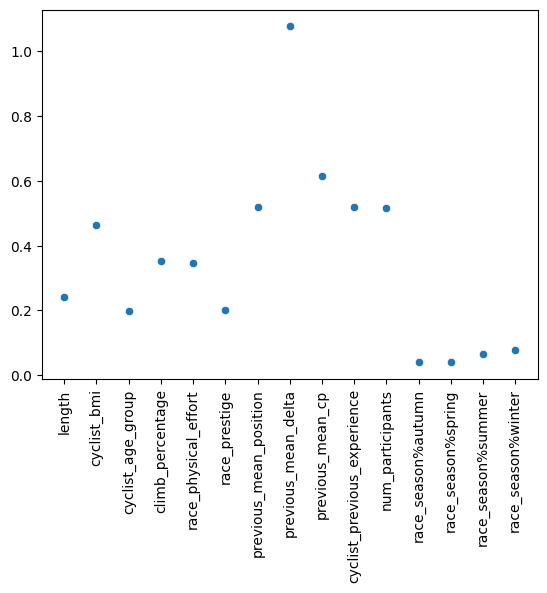

In [16]:
sb.scatterplot(x=dev_set.columns.tolist(), y=maximum_differences_per_feature)
plt.xticks(rotation=90);

In [17]:
interventional_explanations_df = pd.DataFrame(interventional_explanations.values, columns=dev_set.columns.tolist())
interventional_explanations_df.describe().drop("count", axis="rows")

,length,cyclist_bmi,cyclist_age_group,climb_percentage,race_physical_effort,race_prestige,previous_mean_position,previous_mean_delta,previous_mean_cp,cyclist_previous_experience,num_participants,race_season%autumn,race_season%spring,race_season%summer,race_season%winter
mean,-0.015385,-0.045188,0.018068,-0.019140,-0.097492,-0.007720,-0.325641,0.063626,-0.072111,0.017025,0.148207,0.000051,-0.000834,0.005772,-0.004339
std,0.153649,0.390317,0.262484,0.260035,0.455407,0.192327,1.325555,0.409540,0.365262,0.265116,0.311244,0.001869,0.024602,0.028990,0.028130
min,-1.138783,-2.225408,-1.111664,-1.698295,-2.417540,-1.721616,-5.532534,-1.501584,-2.900923,-1.728625,-0.472538,-0.058207,-0.174130,-0.133052,-0.277323
25%,-0.092216,-0.243649,-0.136092,-0.108678,-0.303659,-0.121337,-1.183478,-0.190144,-0.221574,-0.106012,-0.028484,-0.000878,-0.014831,-0.013043,-0.007577
50%,-0.013758,-0.017148,0.076075,0.020156,0.014769,-0.002880,-0.295679,0.054876,-0.000031,0.065099,0.107626,0.000094,-0.002996,0.004169,0.002117
75%,0.061597,0.180209,0.207167,0.126867,0.192175,0.112115,0.562836,0.323101,0.145484,0.186006,0.253638,0.000983,0.011296,0.022594,0.008071
max,1.199083,1.900379,0.671361,0.879991,1.365107,0.998561,4.305218,1.653914,0.931475,1.029751,3.761463,0.064165,0.164436,0.161714,0.228295


In [18]:
distributional_explanations_df = pd.DataFrame(distributional_explanations.values, columns=dev_set.columns.tolist())
distributional_explanations_df.describe().drop("count", axis="rows")

,length,cyclist_bmi,cyclist_age_group,climb_percentage,race_physical_effort,race_prestige,previous_mean_position,previous_mean_delta,previous_mean_cp,cyclist_previous_experience,num_participants,race_season%autumn,race_season%spring,race_season%summer,race_season%winter
mean,-0.028943,-0.128709,-0.037221,-0.056744,-0.091887,-0.021781,-0.248712,-0.003473,-0.121031,-0.039536,0.058158,-0.002825,-0.001694,0.003552,-0.005119
std,0.159718,0.386063,0.230626,0.269200,0.458360,0.190649,1.203656,0.313334,0.300248,0.247180,0.286863,0.003690,0.024346,0.022555,0.028572
min,-1.288122,-2.499875,-1.045175,-1.997653,-2.395134,-1.699790,-5.253061,-1.915188,-2.552077,-1.694180,-0.590825,-0.047078,-0.143479,-0.134475,-0.300802
25%,-0.098906,-0.319617,-0.153015,-0.149409,-0.303146,-0.134667,-1.001234,-0.188977,-0.241627,-0.154682,-0.105372,-0.003619,-0.015697,-0.009661,-0.009561
50%,-0.016590,-0.097014,0.012767,-0.005339,0.014812,-0.017430,-0.237361,-0.007085,-0.066871,0.007346,0.021407,-0.001887,-0.003690,0.003595,0.001791
75%,0.051479,0.087062,0.121435,0.100478,0.193494,0.093452,0.517158,0.189887,0.062860,0.117580,0.159193,-0.000909,0.010828,0.016671,0.008116
max,1.239994,1.897270,0.602804,0.808017,1.381453,0.932975,4.381815,1.392694,0.694123,0.841694,3.322267,0.062527,0.156503,0.143491,0.245355


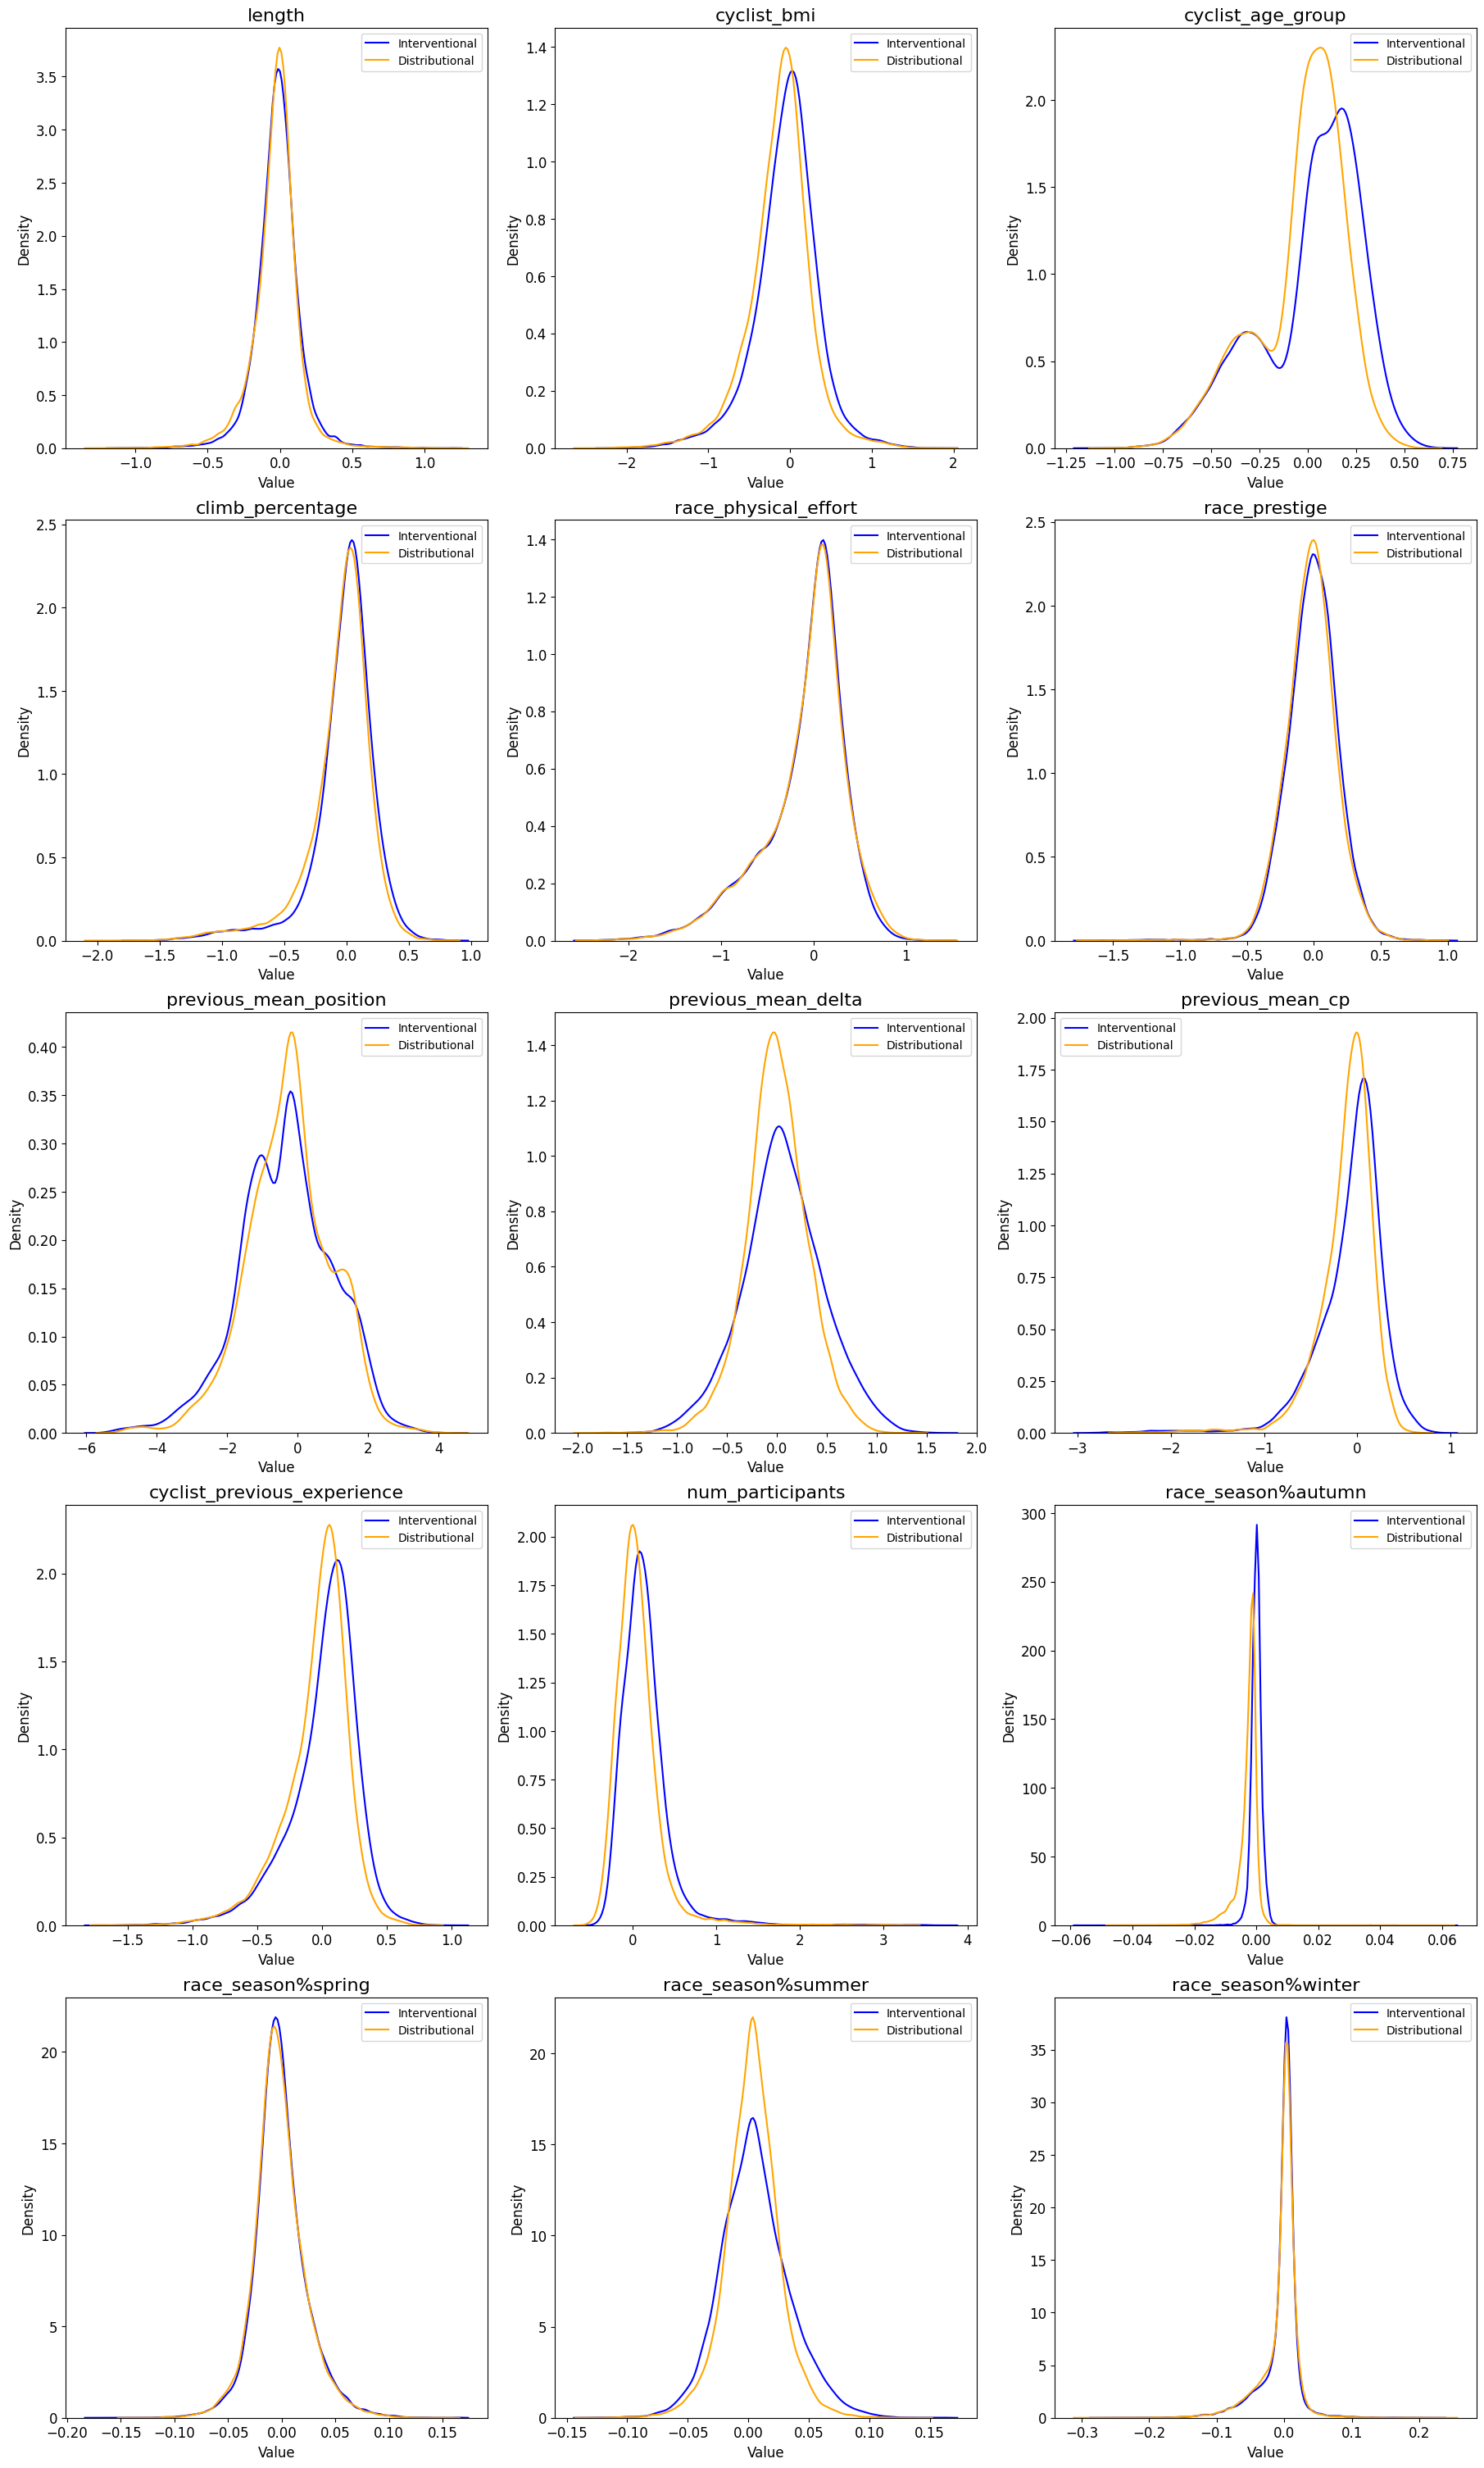

In [19]:
features = interventional_explanations_df.columns  


num_features = len(features)


plots_per_row = 3
num_rows = (num_features + plots_per_row - 1) // plots_per_row 


fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(18, 6 * num_rows), constrained_layout=True)


axes = axes.flatten()

for i, feature in enumerate(features):
    sb.kdeplot(interventional_explanations_df[feature], label='Interventional', color='blue', ax=axes[i])
    sb.kdeplot(distributional_explanations_df[feature], label='Distributional', color='orange', ax=axes[i])
    
    axes[i].set_title(f'{feature}', fontsize=16)
    axes[i].set_xlabel('Value', fontsize=12)
    axes[i].set_ylabel('Density', fontsize=12)
    axes[i].legend(fontsize=10)

    axes[i].tick_params(axis='x', labelsize=12) 
    axes[i].tick_params(axis='y', labelsize=12)  


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])


plt.show()